In [6]:
import numpy as np
import pandas as pd
data=pd.read_csv("C:\\Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
import matplotlib.pyplot as plt
plot_size = plt.rcParams["figure.figsize"]
print(plot_size[0])
print(plot_size[1])
plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size

6.4
4.8


<Axes: ylabel='count'>

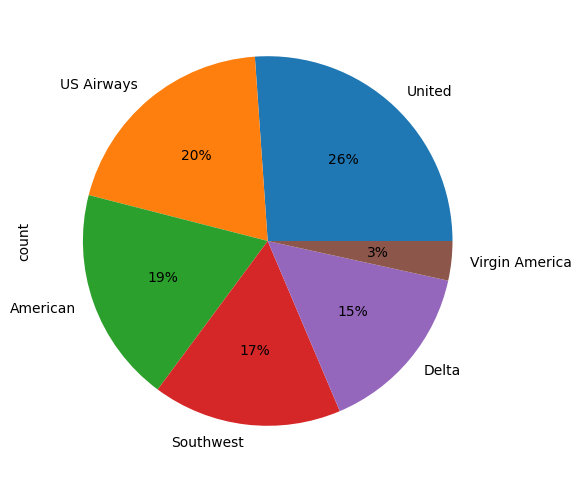

In [12]:
data.airline.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: ylabel='count'>

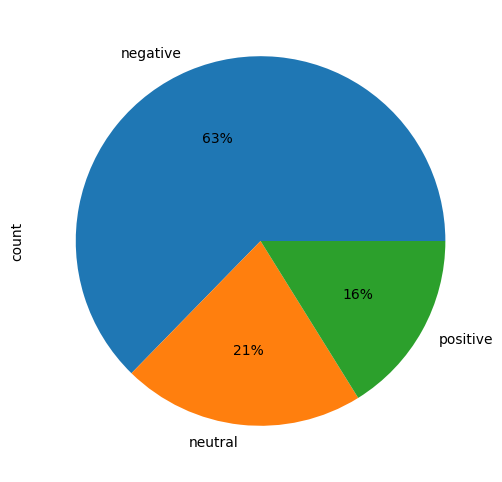

In [13]:
data.airline_sentiment.value_counts().plot(kind='pie',autopct='%1.0f%%')

<Axes: xlabel='airline'>

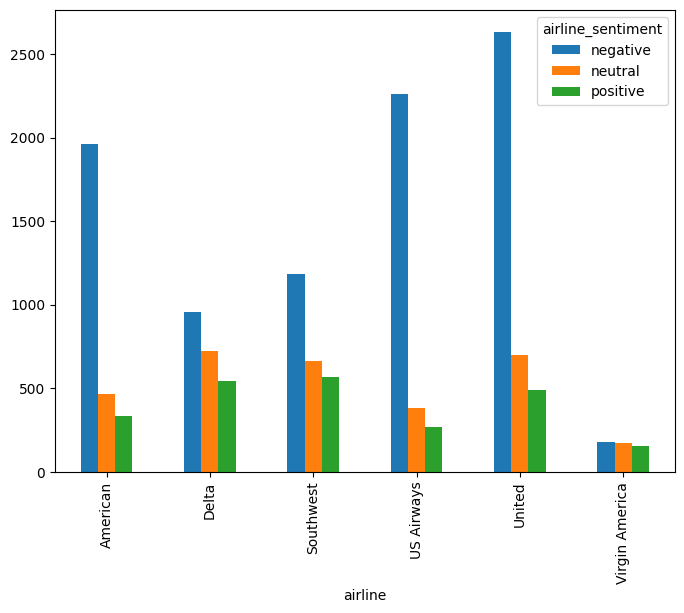

In [18]:
airline_sentiment = data.groupby(['airline','airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

<Axes: xlabel='airline_sentiment', ylabel='airline_sentiment_confidence'>

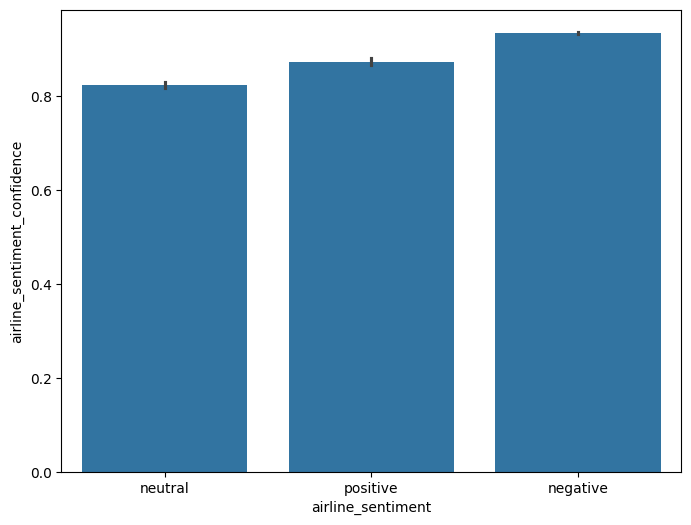

In [19]:
import seaborn as sns
sns.barplot(x='airline_sentiment', y="airline_sentiment_confidence", data=data)

In [41]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from nltk.corpus import stopwords
from nltk import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score
import string
import matplotlib.pyplot as plt;

In [42]:
stop_words = stopwords.words('english') 

In [44]:
def clean_text(txt):
    
    """
    removing all hashtags , punctuations, stop_words  and links, also stemming words 
    """
    txt = txt.lower()
    txt = re.sub(r"(@\S+)", "", txt)  
    txt = txt.translate(str.maketrans('', '', string.punctuation)) 
    txt = re.sub(r"(http\S+|http)", "", txt) 
    txt = ' '.join([PorterStemmer().stem(word=word) for word in txt.split(" ") if word not in stop_words ]) 
    txt = ''.join([i for i in txt if not i.isdigit()]).strip() 
    return txt

In [47]:
print('Original Text : ',data['text'][3])  
print('Processed Text : ',clean_text(data['text'][3]))

Original Text :  @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
Processed Text :  realli aggress blast obnoxi entertain guest face amp littl recours


In [48]:
data['sent_encoded'] = data['airline_sentiment'].apply(lambda x:0 if x =='negative' else 1)
data['cleaned_text'] = data['text'].apply(clean_text)  

In [54]:
def train_test_data():   
    y = data['sent_encoded']   
    X = data['cleaned_text']
     
    text_train, text_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)   
    vect = CountVectorizer(min_df=5, ngram_range=(1, 4)) 
    X_train = vect.fit(text_train).transform(text_train) 
    X_test = vect.transform(text_test) 
    feature_names = vect.get_feature_names_out()
  
    return X_train, X_test, y_train, y_test, feature_names

In [55]:
 X_train, X_test, y_train, y_test, feature_names = train_test_data()

In [56]:
print(X_train.shape)
print(X_test.shape)

(11712, 3831)
(2928, 3831)


In [57]:
lgstc = LogisticRegressionCV(class_weight={1:0.515,0:0.485})
lgstc.fit(X_train, y_train)

LogisticRegressionCV(class_weight={0: 0.485, 1: 0.515})

In [58]:
def print_model_performance(model,X_train,X_test,y_train,y_test):
    training_sample = model.predict(X_train)
    testing_sample = model.predict(X_test)
    print('training ')
    print('train accuracy ',accuracy_score(training_sample, y_train))
    print('train precision_score ',precision_score(training_sample, y_train)) 
    print('train recall score',recall_score(training_sample, y_train)) 
    
    print('\n testing  ')
    print(classification_report(testing_sample, y_test))   
    print('test average accuracy ',accuracy_score(testing_sample, y_test))
    print('test average precision_score ',precision_score(testing_sample, y_test)) 
    print('test average recall score',recall_score(testing_sample, y_test)) 
    print('test AUC ',roc_auc_score(testing_sample, y_test))
    
    print(confusion_matrix(testing_sample, y_test))

In [59]:
print_model_performance(lgstc, X_train, X_test, y_train, y_test)

training 
train accuracy  0.8738046448087432
train precision_score  0.82811080835604
train recall score 0.8349358974358975

 testing  
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1899
           1       0.74      0.76      0.75      1029

    accuracy                           0.82      2928
   macro avg       0.80      0.81      0.81      2928
weighted avg       0.82      0.82      0.82      2928

test average accuracy  0.8220628415300546
test average precision_score  0.7400756143667296
test average recall score 0.760932944606414
test AUC  0.8080599425507056
[[1624  275]
 [ 246  783]]
